In [21]:
#ilgili kütüphanelerin tanımlanması
from keras.utils import to_categorical #kategorik verileri one-hot encoding formatına dönüştürmek için kullanılır
from keras.preprocessing.image import load_img #Resim dosyalarını yüklemek için kullanılır, görüntüleri işlemek için ihtiyacımız var.
from keras.models import Sequential #Ardışık model tanımlamak için kullanacağız; katmanların sırayla eklenmesini sağlar.
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D #Farklı katman türlerini tanımlamak için kullanılır; CNN mimarisini oluşturmak için gereklidir.
import os #Dosya ve dizin işlemleri için kullanacağız.
import pandas as pd # Veri manipülasyonu ve analizi için kullanılır; etiketler ve diğer verilerle çalışmak için DataFrame yapısını sağlar.
import numpy as np #Matematiksel işlemlerin yapılması için gereklidir.
from tqdm.notebook import tqdm

In [22]:
#veri setlerinin konumları
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [23]:
def create_dataframe(dir):
    image_files = [] #görüntüleri saklamak için liste oluşturduk
    categories = [] #etiketler için bir liste oluşturduk
    for category in os.listdir(dir): #dizideki etkiletler için döngü başlattık
        for image_name in os.listdir(os.path.join(dir,category)): #her etiket altındaki görüntülerin isimleri için döngü başlattık
            image_files.append(os.path.join(dir,category,image_name)) #görüntünün yolunu listeye ekledik
            categories.append(category) #etiketi listeye ekledik 
        print(category, "completed") #işlem tamamlandığında bilgi veriyoruz
    return image_files,categories

In [24]:
train = pd.DataFrame() #burada eğittiğimiz verilerini saklayacağız
train['image'] , train['category'] = create_dataframe(TRAIN_DIR) # image kısmına görüntülerin yolunu,label kısmına etiketleri ekliyoruz.

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [25]:
print(train) #train verileri yazdırdık

                                image  category
0            images/train\angry\0.jpg     angry
1            images/train\angry\1.jpg     angry
2           images/train\angry\10.jpg     angry
3        images/train\angry\10002.jpg     angry
4        images/train\angry\10016.jpg     angry
...                               ...       ...
24414  images/train\surprise\9969.jpg  surprise
24415  images/train\surprise\9985.jpg  surprise
24416  images/train\surprise\9990.jpg  surprise
24417  images/train\surprise\9992.jpg  surprise
24418  images/train\surprise\9996.jpg  surprise

[24419 rows x 2 columns]


In [26]:
test = pd.DataFrame() #burada test verilerini saklayacağız
test['image'], test['category'] = create_dataframe(TEST_DIR)  # image kısmına görüntülerin yolunu,category kısmına etiketleri ekliyoruz.

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [27]:
print(test)#test verilerini yazdırdık
print(test['image'])

                              image  category
0       images/test\angry\10052.jpg     angry
1       images/test\angry\10065.jpg     angry
2       images/test\angry\10079.jpg     angry
3       images/test\angry\10095.jpg     angry
4       images/test\angry\10121.jpg     angry
...                             ...       ...
7061  images/test\surprise\9806.jpg  surprise
7062  images/test\surprise\9830.jpg  surprise
7063  images/test\surprise\9853.jpg  surprise
7064  images/test\surprise\9878.jpg  surprise
7065   images/test\surprise\993.jpg  surprise

[7066 rows x 2 columns]
0         images/test\angry\10052.jpg
1         images/test\angry\10065.jpg
2         images/test\angry\10079.jpg
3         images/test\angry\10095.jpg
4         images/test\angry\10121.jpg
                    ...              
7061    images/test\surprise\9806.jpg
7062    images/test\surprise\9830.jpg
7063    images/test\surprise\9853.jpg
7064    images/test\surprise\9878.jpg
7065     images/test\surprise\993.jpg
Name:

In [28]:
from tqdm.notebook import tqdm
from PIL import Image

In [29]:
def extract_features(image_list):
    feature_set = []  # Görüntü özelliklerini saklayacağımız listeyi oluşturduk
    for img_path in tqdm(image_list): # Her görüntü için döngü başlattık
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale') # Görüntüyü belirli boyutlarda yükledik
        img_array = np.array(img) # Görüntüyü numpy dizisine çevirdik
        feature_set.append(img_array) # Görüntü özelliklerini listeye ekledik
    feature_set = np.array(feature_set) # Listeyi numpy dizisine dönüştürdük
    feature_set = feature_set.reshape(len(feature_set),48,48) # Listeyi numpy dizisine dönüştürdük
    return feature_set

In [30]:
train_features = extract_features(train['image'])

  0%|          | 0/24419 [00:00<?, ?it/s]

In [31]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [32]:
x_train = train_features/255.0 # train verilerini normalize ettik ve 0-1 aralığına getirdik
x_test = test_features/255.0 # test verilerini normalize ettik ve 0-1 aralığına getirdik

In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
label_encoder= LabelEncoder() # Etiketleri sayısal değerlere dönüştürmek için bir LabelEncoder nesnesi oluşturduk
label_encoder.fit(train['category']) # Eğitim etiketlerini dönüştürmek için LabelEncoder'ı eğittik

LabelEncoder()

In [35]:
y_train = label_encoder.transform(train['category']) # Eğitim etiketlerini sayısal değerlere dönüştürdük
y_test = label_encoder.transform(test['category']) # Test etiketlerini sayısal değerlere dönüştürdük

In [36]:
y_train = to_categorical(y_train,num_classes = 7) # verileri kategorilere ayırdık
y_test = to_categorical(y_test,num_classes = 7) # verileri kategorilere ayırdık

In [37]:
# Model oluşturma
model = Sequential() # Boş bir model oluşturduk

# Evrişim katmanları
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1))) # İlk evrişim katmanı: 128 filtre, 3x3 çekirdek boyutu, ReLU aktivasyon fonksiyonu, giriş şekli 48x48x1
model.add(MaxPooling2D(pool_size=(2,2))) # Havuzlama katmanı: 2x2 havuzlama uygulayarak özellikleri azaltıyoruz
model.add(Dropout(0.4)) # Dropout katmanı: Aşırı öğrenmeyi önlemek için %40 oranında düzensizlik ekliyoruz

model.add(Conv2D(256, kernel_size=(3,3), activation='relu')) # İkinci evrişim katmanı: 256 filtre ile
model.add(MaxPooling2D(pool_size=(2,2))) # İkinci havuzlama katmanı
model.add(Dropout(0.4)) # İkinci dropout katmanı

model.add(Conv2D(512, kernel_size=(3,3), activation='relu')) # Üçüncü evrişim katmanı: 512 filtre ile
model.add(MaxPooling2D(pool_size=(2,2))) # Üçüncü havuzlama katmanı
model.add(Dropout(0.4)) # Üçüncü dropout katmanı

model.add(Conv2D(512, kernel_size=(3,3), activation='relu')) # Dördüncü evrişim katmanı: 512 filtre ile
model.add(MaxPooling2D(pool_size=(2,2))) # Dördüncü havuzlama katmanı
model.add(Dropout(0.4)) # Dördüncü dropout katmanı

model.add(Flatten()) # Çok katmanlı algılayıcı (Dense) katmanlarına geçiş yapmak için çıkışları düzleştiriyoruz
# Tam bağlı (fully connected) katmanlar
model.add(Dense(512, activation='relu')) # İlk tam bağlı katman: 512 nöron ve ReLU aktivasyon fonksiyonu
model.add(Dropout(0.4)) # İlk dropout katmanı
model.add(Dense(256, activation='relu')) # İkinci tam bağlı katman: 256 nöron ve ReLU aktivasyon fonksiyonu
model.add(Dropout(0.3)) # İkinci dropout katmanı
# Çıkış katmanı
model.add(Dense(7, activation='softmax')) # Son katman: 7 nöron (sınıf sayısı) ve softmax aktivasyon fonksiyonu, sınıflar arasında olasılık dağılımı verir

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from keras.callbacks import ModelCheckpoint # ModelCheckpoint sınıfını keras'tan içe aktardık
from sklearn.model_selection import train_test_split # Eğitim ve test veri setlerini ayırmak için

# Ağırlıkları kaydetmek için geri çağırma oluşturma
checkpoint_filepath = 'emotiondetector_checkpoint.weights.h5' # Ağırlıkların kaydedileceği dosya yolu
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, # Dosya yolunu belirtiyoruz
    save_weights_only=True,  # Yalnızca modelin ağırlıklarını kaydetmek için ayar
    monitor='accuracy',  # Modelin doğruluğunu izleme
    mode='max',  # En yüksek doğruluk değerini hedefleme
    save_best_only=True  # Sadece en iyi doğruluk değerine ulaşıldığında ağırlıkları kaydet
)

In [39]:
model.compile(
    optimizer='adam',  # Adam optimizasyon algoritmasını kullanıyoruz
    loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma kaybı olarak kategorik çapraz entropiyi belirledik
    metrics=['accuracy'] # Modelin başarısını izlemek için doğruluk metriğini ekledik
)

In [40]:
history = model.fit(
    x_train, y_train, # Eğitim verileri ve etiketleri
    batch_size=128, # Her bir güncelleme için kullanılacak örnek sayısı
    epochs=50, # Toplam eğitim döngüsü sayısı
    validation_data=(x_test, y_test),  # Doğrulama verisi olarak test seti kullanılıyor
    callbacks=[model_checkpoint_callback]  # Model ağırlıklarını kaydetmek için geri çağırmayı ekliyoruz
)


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.2833 - loss: 1.7429 - val_accuracy: 0.2583 - val_loss: 1.9326
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.2961 - loss: 1.7078 - val_accuracy: 0.2622 - val_loss: 1.9564
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.3234 - loss: 1.6460 - val_accuracy: 0.3796 - val_loss: 1.7329
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.4105 - loss: 1.4941 - val_accuracy: 0.4115 - val_loss: 1.6636
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.4552 - loss: 1.4013 - val_accuracy: 0.4416 - val_loss: 1.5931
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.4827 - loss: 1.3444 - val_accuracy: 0.4502 - val_loss: 1.5285
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5094 - loss: 1.2859 - val_accuracy: 0.4714 - val_loss: 1.5029
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.5195 - loss: 1.2635 - val_accu

In [41]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")


In [42]:
from keras.models import model_from_json

In [43]:
json_file = open("emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("emotiondetector.h5")

In [44]:
category = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [45]:
import numpy as np
def preprocess_image(img_path):  # Görüntü işleme fonksiyonu
    img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')  # Görüntüyü yükleyip yeniden boyutlandırıyoruz
    image_feature = np.array(img) # Görüntüyü NumPy dizisine dönüştürüyoruz
    image_feature = image_feature.reshape(1,48,48,1)  # Görüntüyü 4 boyutlu diziye dönüştürüyoruz (1, 48, 48, 1)
    return image_feature/255.0 # Görüntüyü normalleştirerek döndürüyoruz
    

In [46]:
from tensorflow.keras.preprocessing.image import load_img
image_path = 'images/train/sad/42.jpg' # Örnek görüntünün dosya yolu
print("original image is of sad")  # Görüntünün orijinal sınıflandırması
img_array = preprocess_image(image_path)  # Görüntüyü işliyoruz
prediction = model.predict(img_array) # Model ile tahmin yapıyoruz
prediction_category = category[prediction.argmax()] # En yüksek tahmin olasılığına sahip etiketi alıyoruz
print("model prediction is ",prediction_category)  # Modelin tahminini yazdırıyoruz

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
model prediction is  sad


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
model prediction is  sad


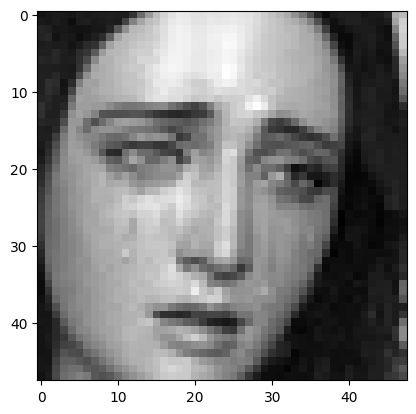

In [48]:
image_path = 'images/train/sad/159.jpg'
print("original image is of sad")
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
prediction_label = category[prediction.argmax()]
print("model prediction is ",prediction_category)
plt.imshow(img_array.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
model prediction is  sad


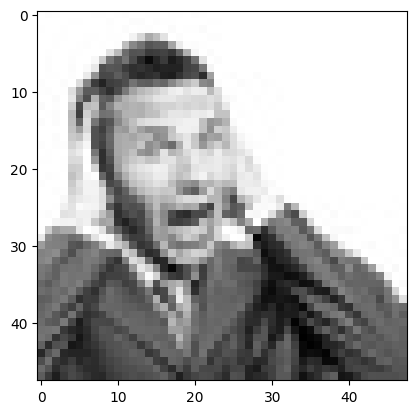

In [49]:
image_path = 'images/train/fear/17.jpg'
print("original image is of fear")
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
prediction_label = category[prediction.argmax()]
print("model prediction is ",prediction_category)
plt.imshow(img_array.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
model prediction is  sad


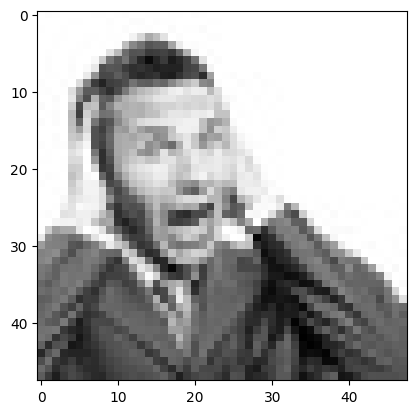

In [50]:
image = 'images/train/disgust/1265.jpg'
print("original image is of disgust")
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
prediction_label = category[prediction.argmax()]
print("model prediction is ",prediction_category)
plt.imshow(img_array.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
model prediction is  sad


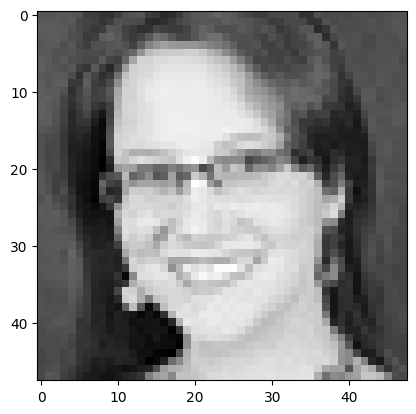

In [51]:
image_path = 'images/train/happy/7.jpg'
print("original image is of happy")
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
prediction_label = category[prediction.argmax()]
print("model prediction is ",prediction_category)
plt.imshow(img_array.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
model prediction is  sad


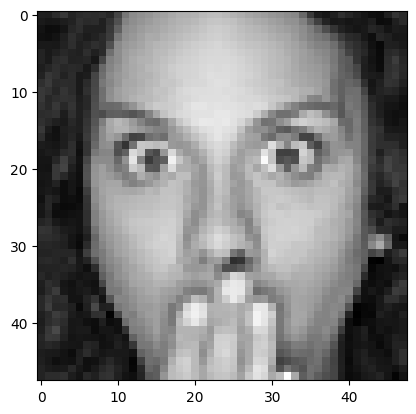

In [52]:
image_path = 'images/train/surprise/5026.jpg'
print("original image is of surprise")
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
prediction_label = category[prediction.argmax()]
print("model prediction is ",prediction_category)
plt.imshow(img_array.reshape(48,48),cmap='gray')